## <u>Goal</u>
### Perform explorative analysis and evaluation of predicted extractive summaries against abstracts from research papers related to coronaviruses. Rouge score is used to understand how closely the predicted summaries align with the abstracts.

In [1]:
import glob
import json
import spacy
import pandas as pd
import random
from rouge import Rouge
from summa import summarizer
from sklearn.model_selection import train_test_split
#from spacy_langdetect import LanguageDetector
import matplotlib.pyplot as plt
import numpy as np

## Data loading and cleaning
   1. Load papers into a dataframe.
   2. Filter papers without an abstract or body text.
   3. Filter non-english papers.

In [2]:
path = '/home/ubuntu/data/*.json'
files = glob.glob(path)
papers = []
for file in files:
    with open(file) as json_file:
            text = json.load(json_file)
            papers.append([text['paper_id'], text['bodytext'], text['abstract']])
data = pd.DataFrame(papers, columns = ['paper_id', 'bodytext', 'abstract'])
filter = (data.abstract != "") & (data.bodytext != "")
data = data[filter]

data['len_bt'] = data.bodytext.map(lambda x: len(x.split(" ")))
data['len_ab'] = data.abstract.map(lambda x: len(x.split(" ")))


data.query('len_bt>=10 and len_ab >=10', inplace = True)

#identify languages of texts to filter out non-english papers
data['bt_lang'] = data.bodytext.map(lambda x: detect(x))
data['ab_lang'] = data.abstract.map(lambda x: detect(x))

#use only english papers
data = data[(data['bt_lang'] == 'en') & (data['ab_lang'] == 'en')]

x = data.drop('abstract', axis = 1)
y = data.abstract


#### Dataset size after cleaning and filtering  = 8755 

In [3]:
data.shape

(8755, 3)

#### Splitting dataset into 80% training set and 20% test set

In [4]:
X_train, Y_train, X_test, Y_test = train_test_split(x, y, test_size = 0.2, random_state= 10)

#### Apply TextRank algorithm to generate extractive summaries on the most important sentences from body text of a paper. The length of the predicted summaries is limited to the length of the abstracts

In [12]:
#%%timeit
data["textrank_summary"]=data.apply(lambda x: summarizer.summarize(str(x.bodytext), words = x.length_ab), axis = 1)
data[:2]

,paper_id,bodytext,abstract,length_abstract,length_bodytext,textrank_summary_abstractlength
3,5da136317f5b97ed8371d5121d8828f1c9a5372d,Malaria is a mosquito-borne infectious parasi...,"Background: Congenital malaria, in which infa...",330,3087,Cases of congenital malaria reported in Englis...
4,8befdc2bb43130a5e90c11061e8bc8955718a825,"In 2003, the world was struck by the epidemic...","Background: Following the SARS outbreak, the ...",338,4864,A health communication capacity building proje...


### Calculate and plot Rouge scores for predicted summaries and abstracts

### <u>Observations</u>
#### Looking at the plots, the mean F-score for Rouge 1/2/L lies within the range of 0.1 - 0.4 with Rouge 1 performing better than the other which suggests there are more 1-gram matches between predicted summaries and abstracts than 2-grams and LCS. 
#### There are papers with really high Rouge scores and low rouge scores.
#### Papers with high rouge scores >0.80 have same text as the bodytext. Hence, the high scores. 
#### Abstracts that have word length less than 100 may need to be removed from corpus as the word length seems too less to have good quality text in it.

In [13]:
def cal_rougescore(row,metric, measure):
    if row.textrank_summary == "":
        return 0
    else:
        return evaluator.get_scores(str(row.textrank_summary), str(row.abstract))[0][metric][measure]

In [14]:
evaluator = Rouge()
#,data["rouge_2"],data["rouge-l"]  
data["rouge_1_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'f'), axis = 1)
data["rouge_2_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'f'), axis = 1)
data["rouge_l_f"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'f'), axis = 1)

data["rouge_1_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'p'), axis = 1)
data["rouge_2_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'p'), axis = 1)
data["rouge_l_p"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'p'), axis = 1)

data["rouge_1_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-1', 'r'), axis = 1)
data["rouge_2_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-2', 'r'), axis = 1)
data["rouge_l_r"]= data.apply(lambda x: cal_rougescore(x, 'rouge-l', 'r'), axis = 1)

In [ ]:
plt.figure(figsize = (12,12))
plt.subplot(3, 3, 1)
plt.scatter(data.length_abstract, data.rouge_1_f)
#plt.line(data.length_abstract, np.mean(data.rouge_1_f), linestyle = '--')
plt.title('rouge:F-score')
plt.ylabel('rouge-score')

#plt.xlabel('abstract length')

plt.subplot(3, 3, 2)
plt.scatter(data.length_abstract, data.rouge_1_r)
plt.title('rouge:Recall')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 3)
plt.scatter(data.length_abstract, data.rouge_1_p)
plt.title('rouge:Precision')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 4)
plt.scatter(data.length_abstract, data.rouge_2_f)
#plt.title('rouge-2:F-score')
plt.ylabel('rouge-1-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 5)
plt.scatter(data.length_abstract, data.rouge_2_r)
#plt.title('rouge-2:F-score')
plt.ylabel('rouge-2-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 6)
plt.scatter(data.length_abstract, data.rouge_2_p)
#plt.title('rouge-3:F-score')
plt.ylabel('rouge-3-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 7)
plt.scatter(data.length_abstract, data.rouge_l_f)
#plt.title('rouge-l:F-score')
plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 8)
plt.scatter(data.length_abstract, data.rouge_l_r)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 9)
plt.scatter(data.length_abstract, data.rouge_l_p)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')


#### About 25% of papers have text length less than 175 words. These could be ignored as the word length is too low to contain good information.

In [20]:
data.length_abstract.describe()

count    8755.000000
mean      258.492290
std       177.496159
min         1.000000
25%       175.000000
50%       229.000000
75%       295.000000
max      3705.000000
Name: length_abstract, dtype: float64

#### Clean the dataset by removing abstracts with text length < 50

In [18]:
clean_data = data[data.length_abstract > 100]
clean_data.shape

(8500, 15)

#### Explore Rouge scores with the cleaned dataset

Text(0.5, 0, 'abstract length')

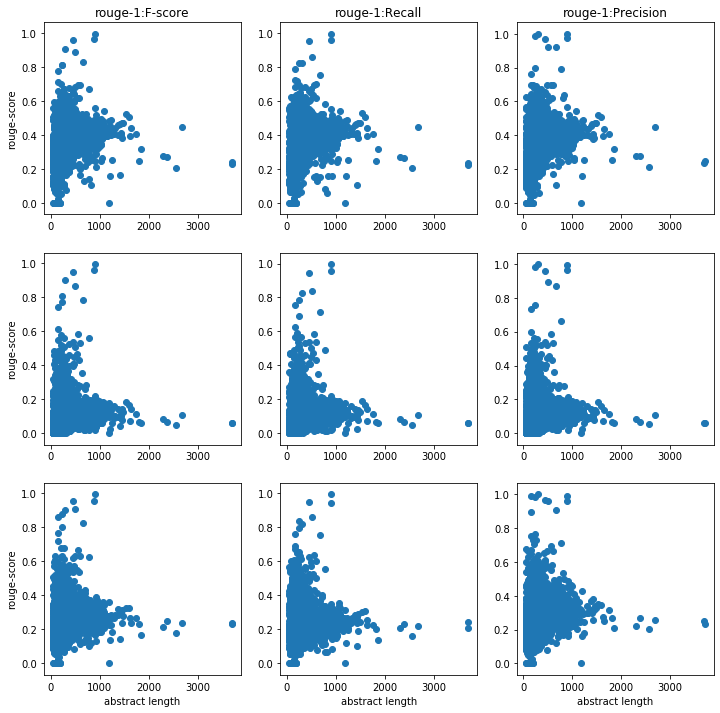

In [19]:
plt.figure(figsize = (12,12))
plt.subplot(3, 3, 1)
plt.scatter(clean_data.length_abstract, clean_data.rouge_1_f)
#plt.line(clean_data.length_abstract, np.mean(clean_data.rouge_1_f), linestyle = '--')
plt.title('rouge-1:F-score')
plt.ylabel('rouge-score')

#plt.xlabel('abstract length')

plt.subplot(3, 3, 2)
plt.scatter(clean_data.length_abstract, clean_data.rouge_1_r)
plt.title('rouge-1:Recall')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 3)
plt.scatter(clean_data.length_abstract, clean_data.rouge_1_p)
plt.title('rouge-1:Precision')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 4)
plt.scatter(clean_data.length_abstract, clean_data.rouge_2_f)
#plt.title('rouge-2:F-score')
plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 5)
plt.scatter(clean_data.length_abstract, clean_data.rouge_2_r)
#plt.title('rouge-2:F-score')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 6)
plt.scatter(clean_data.length_abstract, clean_data.rouge_2_p)
#plt.title('rouge-3:F-score')
#plt.ylabel('rouge-score')
#plt.xlabel('abstract length')

plt.subplot(3, 3, 7)
plt.scatter(clean_data.length_abstract, clean_data.rouge_l_f)
#plt.title('rouge-l:F-score')
plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 8)
plt.scatter(clean_data.length_abstract, clean_data.rouge_l_r)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')

plt.subplot(3, 3, 9)
plt.scatter(clean_data.length_abstract, clean_data.rouge_l_p)
#plt.title('rouge-l:F-score')
#plt.ylabel('rouge-score')
plt.xlabel('abstract length')

In [22]:
data.rouge_1_f.describe()

count    8755.000000
mean        0.371355
std         0.100203
min         0.000000
25%         0.318132
50%         0.380952
75%         0.434603
max         0.997227
Name: rouge_1_f, dtype: float64